# Kepler (with conjugate point test)
![CNES](figs/logo-cnes.png) ![TAS](figs/logo-tas.png)

Minimum time control of the Kepler equation (CNES / TAS / Inria / CNRS collaboration):

$$ t_f \to \min, $$
$$ \ddot{q} = -\frac{\mu}{|q|^3}+\frac{u}{m}\,,\quad t \in [0,t_f], $$
$$ \dot{m} = -\beta|u|,\quad |u| \leq T_{\mathrm{max}}. $$

Fixed initial and final Keplerian orbits (_fixed_ final longitude for conjugate point test).

[Thumbnail](kepler.jpg)

## Initializations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
from nutopy import nle
from nutopy import tools
from nutopy import ocp

ctmax = (3600**2) / 1e6                                             # Conversion from Newtons
mass0 = 1500.                                                       # Initial mass of the spacecraft
beta = 1.42e-02                                                     # Engine specific impulsion
mu = 5165.8620912                                                   # Earth gravitation constant
t0 = 0.                                                             # Initial time (final time is free)
x0 = np.array([ 11.625, 0.75, 0., 6.12e-02, 0., 3.14159265358979 ]) # Initial state (fixed initial longitude)
xf_fixed = np.array([ 42.165, 0., 0., 0., 0., 0. ])                 # Final state (fixed final longitude, see below for each tmax)
n = len(x0)

# tmax = 60 Newtons
#tmax = ctmax * 60.; tf = 15.2055; p0 = -np.array([ .361266, 22.2412, 7.87736, 0., 0., -5.90802 ]); xf_fixed[5] = 10.; N = 1000; nc = 5

# tmax = 9 Newtons
#tmax = ctmax * 9; tf = 93.272; p0 = -np.array([ -4.743728521400288e+00, -7.171314803577050e+01, -2.750468259255777e+00, 4.505679920818070e+01, -3.026794469744788e+00, 2.248091027899508e+00 ]); xf_fixed[5] = 36.; N = 1000; nc = 5

# tmax = 6 Newtons
tmax = ctmax * 6.; tf = 1.32e2; p0 = -np.array([ -4.743728539366440e+00, -7.171314869854240e+01, -2.750468309804530e+00, 4.505679923365745e+01, -3.026794475592510e+00, 2.248091067047670e+00 ]); xf_fixed[5] = 51.; N = 1000; nc = 5

p0 = p0 / np.linalg.norm(p0) # Normalization |p0|=1 for free final time
y = np.hstack((p0, tf)) # initial guess, y = (p0, tf)

## Hamiltonian (`fortran` wrapper)
The first and second derivatives of the code are generated by [Tapenade](http://tapenade.inria.fr:8080/tapenade/index.jsp). Important: arguments `dx` and `dx0` (and `dp` and `dp0`) have been exchanged; the `Tapenade` generated signature was
```fortran
SUBROUTINE HFUN_D_D(t, x, xd0, xd, p, pd0, pd, tmax, mass0, beta, mu, h, hd, hdd, n)
```
while the corrected one is
```fortran
SUBROUTINE HFUN_D_D(t, x, xd, xd0, p, pd, pd0, tmax, mass0, beta, mu, h, hd, hdd, n)
````
This ensures that the signature matches what is expected by `@tensorize`: variations, up to any order, come as `x, dx, d2x, d3x, ...`

In [2]:
!python -m numpy.f2py -c hfun.f90 -m hfun > /dev/null 2>&1
!python -m numpy.f2py -c hfun_d.f90 -m hfun_d > /dev/null 2>&1
!python -m numpy.f2py -c hfun_d_d.f90 -m hfun_d_d > /dev/null 2>&1

from hfun import hfun
from hfun_d import hfun_d
from hfun_d_d import hfun_d_d

hfun = tools.tensorize(hfun_d, hfun_d_d, tvars=(2, 3), full=True)(hfun)
h = ocp.Hamiltonian(hfun)
f = ocp.Flow(h)

## Shooting function

In [3]:
def dshoot(t0, dt0, x0, dx0, p0, dp0, tf, dtf, next=False):
    (xf, dxf), (pf, dpf) = f((t0, dt0), (x0, dx0), (p0, dp0), (tf, dtf), tmax, mass0, beta, mu)
    s = np.zeros(7) # code duplication and full=True
    s[0:6] = xf[0:6] - xf_fixed # fixed final longitude
    s[6] = p0[0]**2 + p0[1]**2 + p0[2]**2 + p0[3]**2 + p0[4]**2 + p0[5]**2 - 1.
    ds = np.zeros(7)
    ds[0:6] = dxf[0:6]
    ds[6] = 2*p0[0]*dp0[0] + 2*p0[1]*dp0[1] + 2*p0[2]*dp0[2] + 2*p0[3]*dp0[3] + 2*p0[4]*dp0[4] + 2*p0[5]*dp0[5]
    if not next: return s, ds
    else: return s, ds, ((tf, dtf), (xf, dxf), (pf, dpf), None)

@tools.vectorize(vvars=(1, 2, 3))
@tools.vectorize(vvars=(4,), next=True)
@tools.tensorize(dshoot, full=True)
def shoot(t0, x0, p0, tf, next=False):
    """s = shoot(t0, x0, p0, tf)

    Shooting function associated with h
    """
    xf, pf = f(t0, x0, p0, tf, tmax, mass0, beta, mu)
    s = np.zeros(7)
    s[0:6] = xf[0:6] - xf_fixed
    s[6] = p0[0]**2 + p0[1]**2 + p0[2]**2 + p0[3]**2 + p0[4]**2 + p0[5]**2 - 1.
    if not next: return s
    else: return s, (tf, xf, pf, None)
    
def jshoot(t0, x0, p0, tf, dx0=None, dp0=None):
    """jac = jshoot(t0, x0, p0, tf)
    
    Jacobian of shooting function wrt. p0 and tf
    Vectorized in tf"""
    n = x0.shape[0]
    if dx0 is None: dx0 = np.zeros((n, n))
    if dp0 is None: dp0 = np.eye(n)
    if isinstance(tf, list): vec = True
    else: vec = False; tf = [ tf ]
    N = len(tf)
    jac = np.zeros((n+1, N, n+1))
    _, jac[0:n, :, :] = shoot([ t0 for i in range(0, n) ], [ (x0, dx0[i, :]) for i in range(0, n) ], [ (p0, dp0[i, :]) for i in range(0, n) ], tf)
    _, jac[  n, :, :] = shoot(t0, x0, p0, [ (tf[j], 1.) for j in range(0, N) ])
    jac = np.transpose(jac, (1, 2, 0)) # axis 0: d/dp0 or dtf (n+1), 1: time vectorization (N), 2: dim of shooting value (n+1)
    if vec: return jac
    else: return jac[0]

## Solve

In [4]:
dfoo = lambda y, dy: shoot(t0, x0, (y[:-1], dy[:-1]), (y[-1], dy[-1]))
foo = lambda y: shoot(t0, x0, y[:-1], y[-1])
foo = tools.tensorize(dfoo, full=True)(foo)

nleopt = nle.Options(SolverMethod='hybrj', Display='on', TolX=1e-8)
et = time.time(); sol = nle.solve(foo, y, df=foo, options=nleopt); y_sol = sol.x; et = time.time() - et
print('Elapsed time:', et)
print('y_sol =', y_sol)
print('foo =', foo(y_sol))


     Calls  |f(x)|                 |x|
 
         1  6.301595264456300e+00  1.320037878244408e+02
         2  2.340071357355818e+00  1.400203658343002e+02
         3  2.400735354119709e+00  1.424118392572792e+02
         4  1.013403473233678e+00  1.421946981533602e+02
         5  2.682895030563751e-01  1.417788071311752e+02
         6  7.955498964446011e-01  1.414641043538589e+02
         7  1.470638840331741e-01  1.418509100088929e+02
         8  4.973211617416135e-02  1.416148603181079e+02
         9  1.219551393639842e-01  1.416431105728263e+02
        10  3.072632648243853e-02  1.416205384607907e+02
        11  8.653617036143087e-03  1.416150551345118e+02
        12  3.801480838671332e-03  1.416129848677609e+02
        13  2.860024581815136e-03  1.416130187627090e+02
        14  1.662360458139482e-03  1.416132110526509e+02
        15  9.636113150738866e-04  1.416133352433271e+02
        16  1.105532175256260e-03  1.416136891521962e+02
        17  1.261272792993838e-05  1.416135006

## Plots

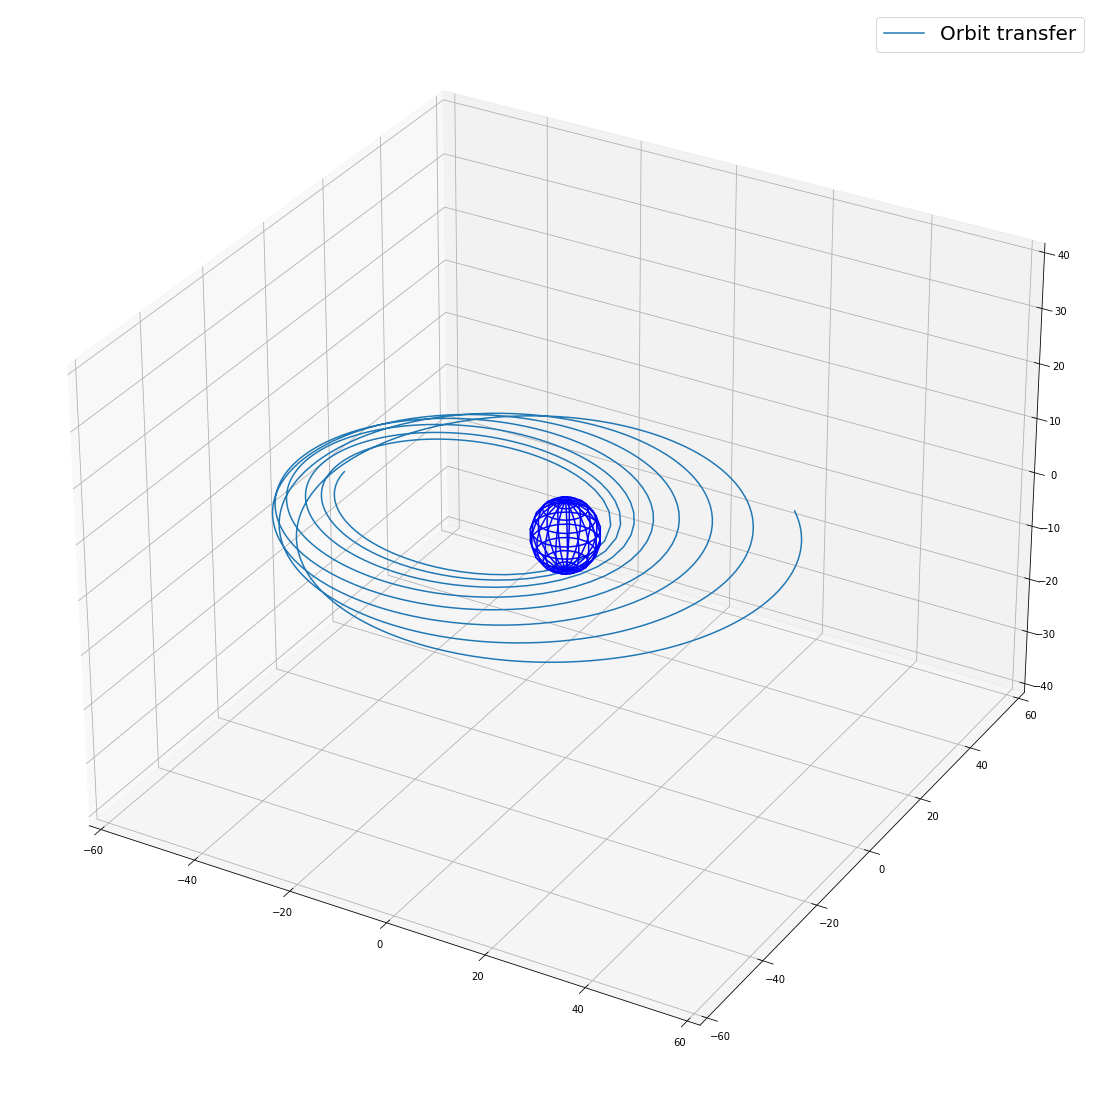

In [5]:
p0 = y_sol[:-1]
tf = y_sol[-1]
tspan = list(np.linspace(0, tf, N+1))
xf, pf = np.array( f(t0, x0, p0, tspan, tmax, mass0, beta, mu) )
P  = xf[:, 0]
ex = xf[:, 1]
ey = xf[:, 2]
hx = xf[:, 3]
hy = xf[:, 4]
L  = xf[:, 5]
cL = np.cos(L)
sL = np.sin(L)
W  = 1+ex*cL+ey*sL
Z  = hx*sL-hy*cL
C  = 1+hx**2+hy**2
q  = np.zeros((N+1, 3))
q[:, 0] = P*( (1+hx**2-hy**2)*cL + 2*hx*hy*sL ) / (C*W)
q[:, 1] = P*( (1-hx**2+hy**2)*sL + 2*hx*hy*cL ) / (C*W)
q[:, 2] = 2*P*Z / (C*W)

plt.rcParams['legend.fontsize'] = 20
plt.rcParams['figure.figsize'] = (20, 20)
fig1 = plt.figure()
ax = fig1.gca(projection='3d')
ax.set_xlim3d(-60, 60) # ax.axis('equal') not supported
ax.set_ylim3d(-60, 60)
ax.set_zlim3d(-40, 40)
u, v = np.mgrid[ 0:2*np.pi:20j, 0:np.pi:10j ]
r = 6.378 # Earth radius (in Mm)
x1 = r*np.cos(u)*np.sin(v)
x2 = r*np.sin(u)*np.sin(v)
x3 = r*np.cos(v)
ax.plot_wireframe(x1, x2, x3, color='b')
ax.plot(q[:, 0], q[:, 1], q[:, 2], label='Orbit transfer')
#ax.quiver(q[:, 0], q[:, 1], q[:, 2], u, v, w, length=0.1, normalize=True)
ax.legend()

## Conjugate point computation


     Calls  |f(x)|                 |x|
 
         1  7.452820308014326e+02  5.219371301468111e+02
         2  7.499244354398687e+01  5.220844406941543e+02
         3  5.854295671065765e+00  5.220709730339374e+02
         4  3.568146879603087e-02  5.220719482577457e+02
         5  1.742250554656049e-05  5.220719542381074e+02
         6  1.868184367148713e-10  5.220719542351887e+02

 Results of the nle solver method:

 xsol    =  522.0719542351887
 f(xsol) =  -1.868184367148713e-10
 nfev    =  6
 njev    =  1
 status  =  1
 success =  True 

 Successfully completed: relative error between two consecutive iterates is at most TolX.


     Calls  |f(x)|                 |x|
 
         1  5.839098509598629e+03  6.836880670878310e+02
         2  7.635989933122853e+02  6.837171213473797e+02
         3  1.202551425483022e+02  6.837214925040061e+02
         4  3.149560057372592e+00  6.837223095695031e+02
         5  1.348484495495010e-02  6.837223315445174e+02
         6  1.606592157326722e-06  

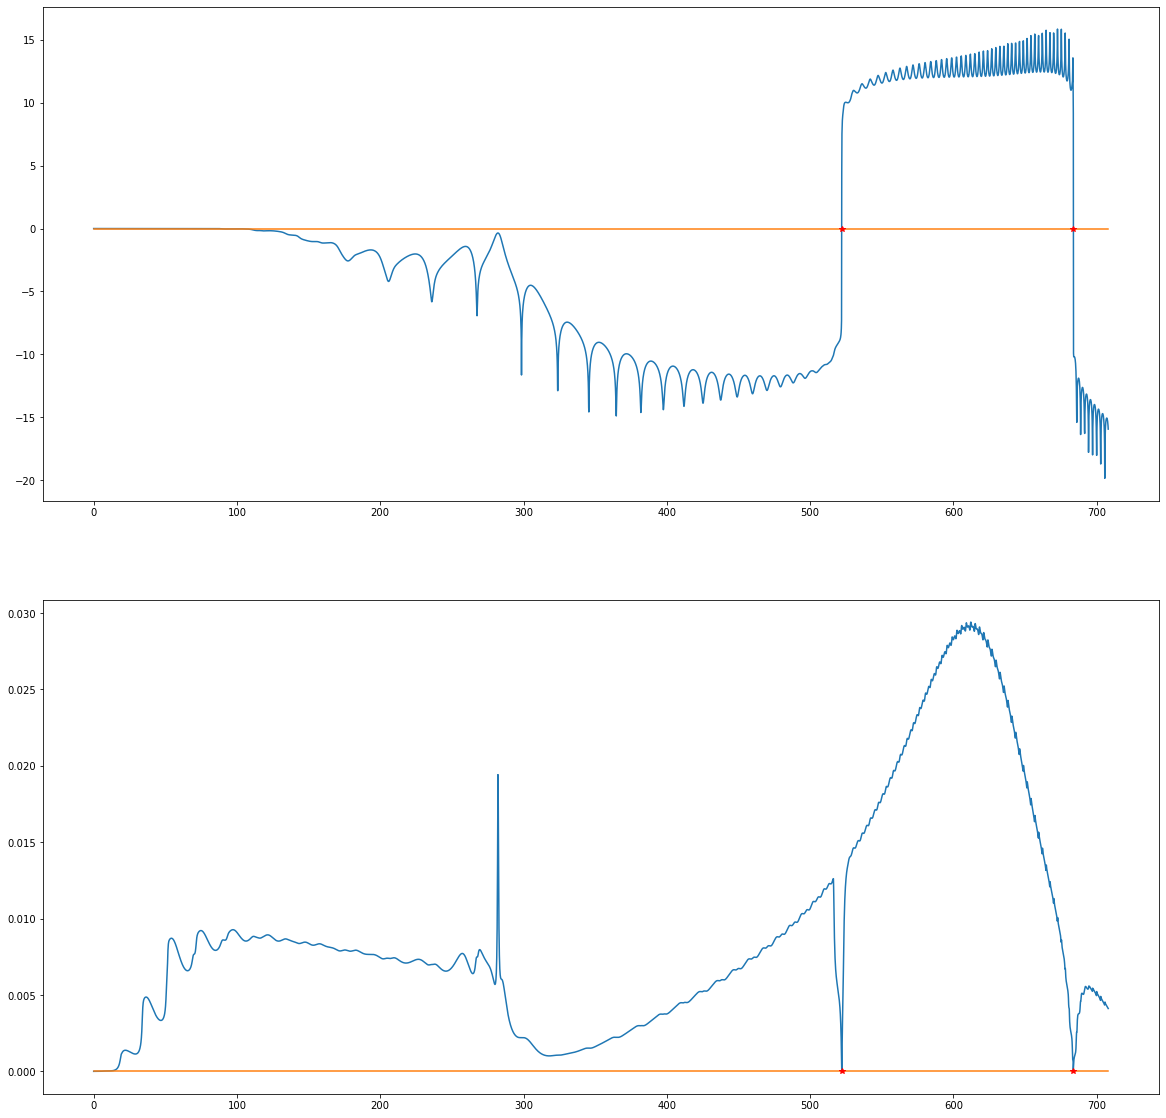

In [6]:
N = nc*N
tspan = list(np.linspace(0, nc*tf, N))
jac = jshoot(t0, x0, p0, tspan)
det = [ np.linalg.det(jac[i]) for i in range(0, N) ]
sn = [ np.linalg.svd(jac[i])[1][-1] for i in range(0, N) ]
fig2 = plt.figure()
ax21 = plt.subplot(2, 1, 1)
ax21.plot(tspan, np.arcsinh(det))
ax21.plot([ tspan[0], tspan[-1]], [ 0, 0 ])
ax22 = plt.subplot(2, 1, 2)
ax22.plot(tspan, sn)
ax22.plot([ tspan[0], tspan[-1]], [ 0, 0 ])

itc = [ i for i in range(0, N-1) if det[i]*det[i+1] < 0 ]
tspan = np.array(tspan)
tc = np.array(tspan[itc])
dx0 = np.zeros((n, n))
dp0 = np.eye(n)
nleopt = nle.Options(Display='on', TolX=1e-8)

for k in range(0, len(itc)):
    dxk, dpk = np.array( f([ t0 for i in range(0, n) ], [ (x0, dx0[i, :]) for i in range(0, n) ], [ (p0, dp0[i, :]) for i in range(0, n) ], tc[k], tmax, mass0, beta, mu) ) 
    xk = dxk[0, 0, :]; dxk = dxk[:, 1, :]
    pk = dpk[0, 0, :]; dpk = dpk[:, 1, :]
    foo = lambda t: np.linalg.det(jshoot(tc[k], xk, pk, t, dxk, dpk))
    sol = nle.solve(foo, tc[k], options=nleopt); tc[k] = sol.x
    ax21.plot(tc[k], 0, 'r*')
    ax22.plot(tc[k], 0, 'r*')

print('tc =', tc)